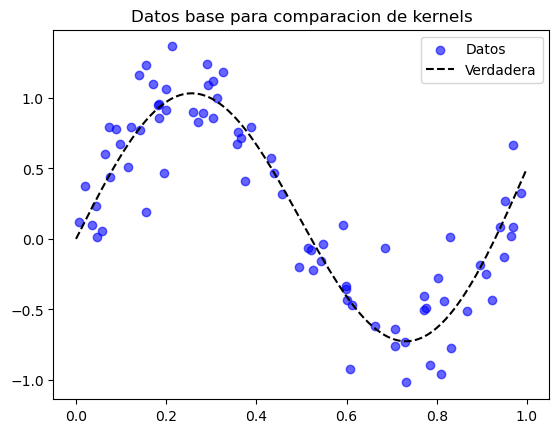

In [11]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# Funcion verdadera (no lineal)
def true_function(x):
    return np.sin(2 * np.pi * x) + 0.5 * x**2

N = 80
x = np.sort(np.random.uniform(0, 1, N))
y = true_function(x) + np.random.normal(0, 0.25, N)

x_test = np.linspace(0, 1, 200)
y_true = true_function(x_test)

# Grafico base para comparar despues
plt.scatter(x, y, color='blue', alpha=0.6, label='Datos')
plt.plot(x_test, y_true, 'k--', label='Verdadera')
plt.legend()
plt.title('Datos base para comparacion de kernels')
plt.show()

In [12]:
# Kernel Gaussiano (ya lo tenemos, recordatorio)
def gaussian_kernel(u):
    return np.exp(-0.5 * u**2) / np.sqrt(2 * np.pi)

# Kernel Epanechnikov (más eficiente, usado en práctica)
# Tecnología inversa: ¿Por qué Epanechnikov? Minimiza AMISE (asymptotic mean integrated squared error)
# Forma cuadrática que cae a 0 en |u| > 1 → compacto, menos sensible a outliers lejanos
def epanechnikov_kernel(u):
    return 0.75 * (1 - u**2) * (np.abs(u) <= 1)

# Kernel tricúbico (más suave en bordes, usado en loess clásico)
# Tecnología inversa: (1 - |u|^3)^3 → cae suavemente a 0, reduce discontinuidades en bordes
def tricube_kernel(u):
    return (1 - np.abs(u)*3)*3 * (np.abs(u) <= 1)

In [13]:
def nadaraya_watson_general(x_new, x_train, y_train, h, kernel_func):
    """
    Nadaraya-Watson genérico
    Tecnología inversa: el kernel pondera localmente → promedio ponderado de y
    h controla el ancho de influencia (tradeoff bias-variance)
    """
    u = (x_new - x_train) / h
    weights = kernel_func(u)
    weight_sum = weights.sum()
    if weight_sum < 1e-10:
        return np.mean(y_train)  # fallback
    weights /= weight_sum
    return np.sum(weights * y_train)


def local_regression(x_new, x_train, y_train, h):
    """
    Local linear regression (loess-style) ponderada con kernel.
    Tecnología inversa: ponderamos localmente y ajustamos una línea (grado 1) en la vecindad.
    """
    u = (x_new - x_train) / h
    weights = gaussian_kernel(u)  # o tricube_kernel si prefieres
    weight_sum = weights.sum()
    if weight_sum < 1e-10:
        return np.mean(y_train)  # fallback
    
    weights /= weight_sum
    
    # Matriz de diseño local: 1 + x_train
    X_loc = np.column_stack((np.ones(len(x_train)), x_train))
    
    # Pesos diagonales
    W = np.diag(weights)
    
    XtWX = X_loc.T @ W @ X_loc
    XtWy = X_loc.T @ W @ y_train
    
    if np.linalg.det(XtWX) < 1e-10:
        return np.mean(y_train)  # fallback
    
    betas = np.linalg.solve(XtWX, XtWy)
    y_pred = betas[0] + betas[1] * x_new
    return y_pred

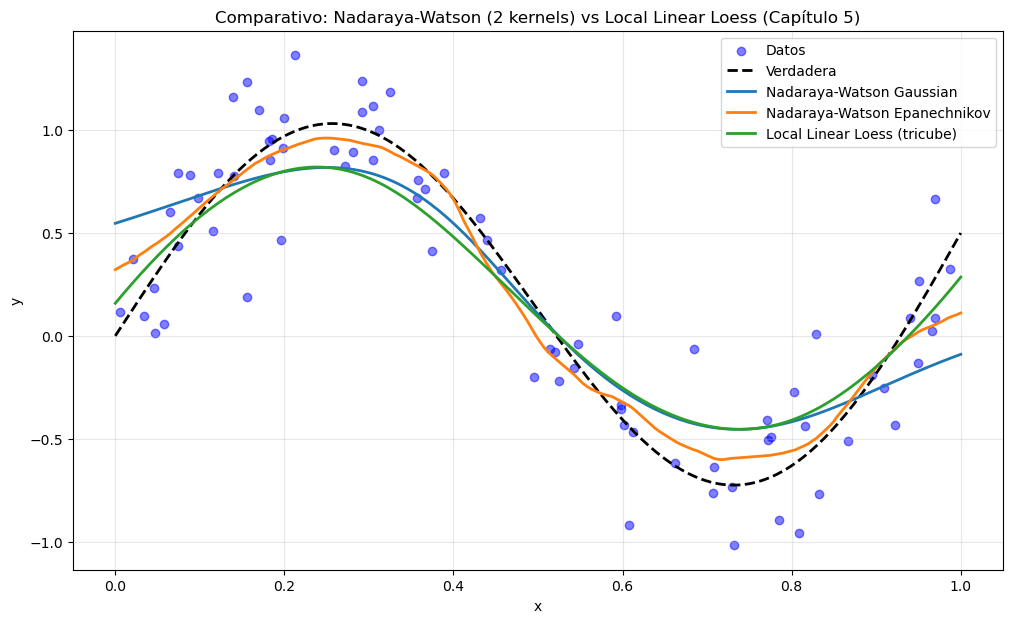

In [14]:
h_compar = 0.12  # valor intermedio encontrado antes

methods = {
    'Nadaraya-Watson Gaussian': lambda xi: nadaraya_watson_general(xi, x, y, h_compar, gaussian_kernel),
    'Nadaraya-Watson Epanechnikov': lambda xi: nadaraya_watson_general(xi, x, y, h_compar, epanechnikov_kernel),
    'Local Linear Loess (tricube)': lambda xi: local_regression(xi, x, y, h_compar)  # reutilizamos de antes
}

plt.figure(figsize=(12, 7))
plt.scatter(x, y, color='blue', alpha=0.5, label='Datos')
plt.plot(x_test, y_true, 'k--', linewidth=2, label='Verdadera')

for name, func in methods.items():
    y_pred = np.array([func(xi) for xi in x_test])
    plt.plot(x_test, y_pred, linewidth=2, label=name)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Comparativo: Nadaraya-Watson (2 kernels) vs Local Linear Loess (Capítulo 5)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()